In [3]:
# Carregando bibliotecas/Pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,\
                            accuracy_score, confusion_matrix, auc

In [4]:
#Lendo o conjunto de dados da tabela ‘Order Semicolon’
#mostrando os 5 primeiros registros com a função head()

semicolon = pd.read_csv('/content/Order_semicolon.csv', sep=';')
semicolon.head()

,id,companyId,containerId,createdAt,customer,displayId,engineId,engineName,engineType,extraInfo,...,orderTiming,orderType,salesChannel,scheduledAt,status,preparationTime,takeOutTimeInSeconds,totalAmount,updatedAt,version
0,1,I0VP1DZXGU,AKVXT2FH,08/01/2025 15:47,525,O8CC98,E3R037,DirectOrder,POS,Adipisci maiores nam eius vero nesciunt sed.,...,IMMEDIATE,DELIVERY,ANOTAAI,NaN,DISPATCHED,45,2131,90.91,09/01/2025 03:32,v3.7.8
1,2,04MEUULZ6W,KKMY5TG5,03/11/2024 22:30,694,HJ99VA,EJVOBV,DirectOrder,APP,NaN,...,IMMEDIATE,DELIVERY,WHATSAPP,NaN,CONCLUDED,33,374,99.69,04/11/2024 03:05,v2.3.0
2,3,W2ZZS7CCZW,I87JLGTV,09/09/2024 05:49,491,XJJDH2,UDX1ZF,KDSPro,POS,NaN,...,IMMEDIATE,INDOOR,EPADOCA,NaN,CONCLUDED,22,247,45.97,09/09/2024 09:32,v1.9.5
3,4,SQ5MBL8L24,W3ZXOQHO,22/05/2025 06:22,846,J8QDM3,30FLOC,KDSPro,WEB,Autem mollitia voluptas quasi.,...,SCHEDULED,TAKEOUT,99FOOD,22/05/2025 14:22,CANCELED,35,1766,104.31,22/05/2025 21:39,v2.8.5
4,5,0RCNJ6BRJD,NA0C0FOS,22/02/2025 01:23,77,H4LV73,QI3URN,KDSPro,POS,NaN,...,SCHEDULED,DELIVERY,99FOOD,24/02/2025 11:23,DISPATCHED,20,1219,105.50,22/02/2025 13:53,v2.1.3


In [5]:
#Aqui uma função foi criada para calcular a distribuição da frequência,
#ou seja, contando a quantidade de vezes que as categorias de
#PENDING;DISPATCHED;PLACED;CONFIRMED;CONCLUDED;CANCELED
#estão aparecendo dentro da planilha e em seguida, fazendo a contagem percentual desse valor.


def freq(x: pd.Series, plot=False):
    contagem = x.value_counts()
    percentual = round((x.value_counts() / x.shape[0]) * 100, 3)
    res = pd.DataFrame({'n': contagem, 'perc': percentual})
    if plot:
        sns.countplot(x)
        plt.show()
    return res
print(freq(semicolon["status"]))


              n   perc
status                
PENDING     363  18.15
DISPATCHED  358  17.90
PLACED      330  16.50
CONFIRMED   321  16.05
CONCLUDED   319  15.95
CANCELED    309  15.45


In [6]:
#obter a porcentagem do total de cada categoria (a função freq mostra isso também)
(semicolon.status.value_counts() / semicolon.shape[0]) * 100

,count
status,
PENDING,18.15
DISPATCHED,17.90
PLACED,16.50
CONFIRMED,16.05
CONCLUDED,15.95
CANCELED,15.45


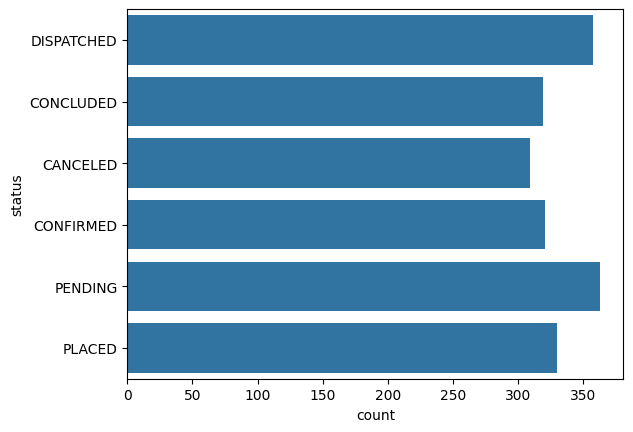

,n,perc
status,,
PENDING,363,18.15
DISPATCHED,358,17.90
PLACED,330,16.50
CONFIRMED,321,16.05
CONCLUDED,319,15.95
CANCELED,309,15.45


In [7]:
#Criar um boxplot com as categorias do status
freq(semicolon.status, plot=True)

In [8]:
##Descreve toda a coluna ‘status’, nisso temos a contagem total dos registros da coluna(count),unique (a contagem de variação dentro dessa coluna),
#top(que é a categoria que aparece com mais frequência) e o total de vezes que essa categoria aparece
semicolon.status.describe()

,status
count,2000
unique,6
top,PENDING
freq,363


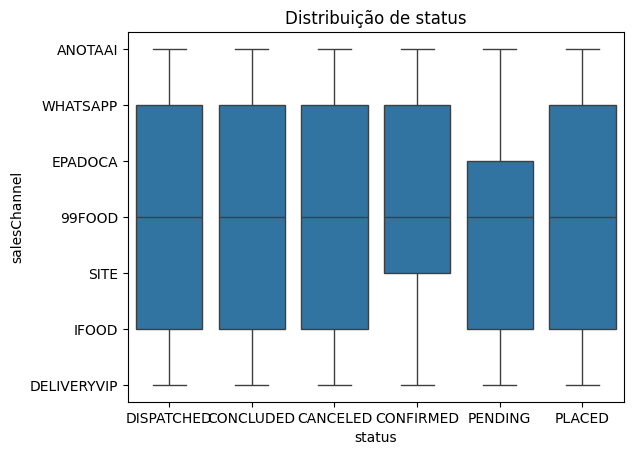

In [9]:
#Nesse outro trecho,
#um box plot é criado para ver como o status dos pedidos se distribui em relação a coluna de canal de vendas (salesChannel).

sns.boxplot(x='status', y='salesChannel', data=semicolon)
plt.title('Distribuição de status')
plt.show()

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Contagem de quantos pedidos de cada categoria de status cada cliente fez.
status_counts = semicolon.groupby(['customer', 'status']).size().reset_index(name='count')

print(status_counts)


      customer      status  count
0            1    CANCELED      1
1            1  DISPATCHED      1
2            1     PENDING      1
3            2    CANCELED      1
4            2  DISPATCHED      2
...        ...         ...    ...
1705       999  DISPATCHED      1
1706       999      PLACED      2
1707      1000   CONFIRMED      1
1708      1000     PENDING      1
1709      1000      PLACED      1

[1710 rows x 3 columns]


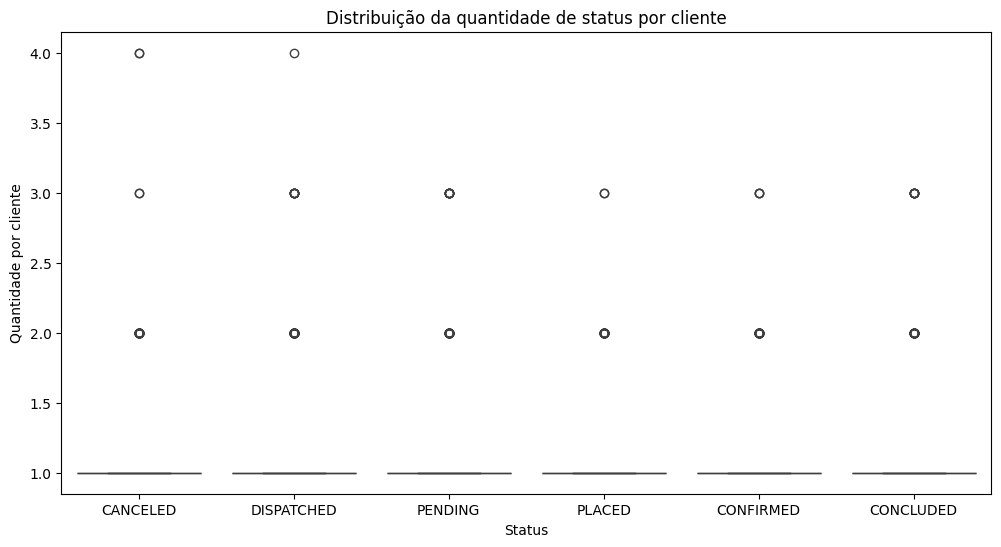

In [11]:

#Demonstrando essa relação de distribuição de status e cliente por meio do boxplot

plt.figure(figsize=(12,6))
sns.boxplot(x='status', y='count', data=status_counts)
plt.title('Distribuição da quantidade de status por cliente')
plt.xlabel('Status')
plt.ylabel('Quantidade por cliente')
plt.show()


In [12]:
# Transformando em categoria: is_canceled, facilitando a identificação
#Quando o pedido está cancelado, essa coluna recebe valor 1.
semicolon['salesChannel'] = semicolon['salesChannel'].astype('category')


In [14]:

semicolon['is_canceled'] = (semicolon['status'] == 'CANCELED').astype(int)


In [15]:
#criando o modelo de regressão, ou seja, criando o modelo para identificar se o pedido vai ser ou não cancelado.
#Adicionando outras colunas
#tempo de preparo (preparationTime)
#tempo de retirada (takeOutTimeInSeconds)
#canal de vendas (salesChannel)

modelo = smf.glm(
    formula='is_canceled ~ preparationTime + takeOutTimeInSeconds + C(salesChannel)',
    data=semicolon,
    family=sm.families.Binomial()
).fit()


In [16]:

#os coeficientes do modelo mostram se cada variável aumenta ou diminui a chance de cancelamento.
print(modelo.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            is_canceled   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -857.76
Date:                Mon, 22 Sep 2025   Deviance:                       1715.5
Time:                        21:23:48   Pearson chi2:                 2.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.003103
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [17]:
#o print está mostrando as razões de chance da regressão logistica, ou seja, o print mostra a chance de cancelamento.
#caso o cancelamento seja >1, tem maior que chance de acontecer
# <1 tem menos chance de acontecer.
print(np.exp(modelo.params[1:]))


C(salesChannel)[T.ANOTAAI]        1.152100
C(salesChannel)[T.DELIVERYVIP]    0.809492
C(salesChannel)[T.EPADOCA]        1.297771
C(salesChannel)[T.IFOOD]          1.037111
C(salesChannel)[T.SITE]           0.962737
C(salesChannel)[T.WHATSAPP]       1.029920
preparationTime                   1.000822
takeOutTimeInSeconds              0.999932
dtype: float64


In [20]:
#aqui estamos transformando os valores em porcentagem , e se o valor for positivo tem maior chance de ser cancelado
#ou se for negativo, tem menor chance
# se for zero, as chances de ser cancelado nao alteram.
(np.exp(modelo.params[1:]) - 1) * 100

,0
C(salesChannel)[T.ANOTAAI],15.209951
C(salesChannel)[T.DELIVERYVIP],-19.050794
C(salesChannel)[T.EPADOCA],29.777136
C(salesChannel)[T.IFOOD],3.711062
C(salesChannel)[T.SITE],-3.726334
C(salesChannel)[T.WHATSAPP],2.992002
preparationTime,0.082224
takeOutTimeInSeconds,-0.006803


In [21]:

#neste momento estamos criando um modelo de regressao logistica, usando o sklearn, transformando os dados
#em categorias de zero e um

model = LogisticRegression(penalty=None, solver='newton-cg')
baseline_df = semicolon[['status', 'orderType', 'salesChannel', 'engineType']].dropna()
#y é que desejamos prever
y = baseline_df.status
# alvo variável, vendo se foi ounao cancelado
#o dummies está transformando as categorias em colunas binarias, zero ou  um
X = pd.get_dummies(baseline_df[['orderType', 'salesChannel', 'engineType']], drop_first=True).astype(int)

print(X)

      orderType_INDOOR  orderType_TAKEOUT  salesChannel_ANOTAAI  \
0                    0                  0                     1   
1                    0                  0                     0   
2                    1                  0                     0   
3                    0                  1                     0   
4                    0                  0                     0   
...                ...                ...                   ...   
1995                 0                  0                     0   
1996                 1                  0                     0   
1997                 1                  0                     0   
1998                 1                  0                     0   
1999                 1                  0                     0   

      salesChannel_DELIVERYVIP  salesChannel_EPADOCA  salesChannel_IFOOD  \
0                            0                     0                   0   
1                            0             

In [22]:

model.fit(X, y)

LogisticRegression(penalty=None, solver='newton-cg')

In [23]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty=None,
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(multi_class='warn', penalty=None, solver='newton-cg')

In [24]:

#resultado dos coeficientes que o modelo de regressão aprendeu,
#Valores positivos- aumentam a chance de um pedido cair naquela categoria.
#Valores negativos− diminuem a chance e numeros proximos de zero não influenciam

print(model.coef_)

[[ 0.16537942  0.01686424  0.12024499 -0.15604251  0.22077249  0.04032833
  -0.02459262  0.03083381 -0.17148404 -0.16666513]
 [-0.13008686  0.08722342  0.22330463  0.38018901  0.22340192  0.32272771
   0.09249069  0.20067212  0.04372011 -0.04571268]
 [-0.05983591 -0.29641533  0.31714535 -0.05680043 -0.19718636 -0.1948463
   0.01056531  0.04333571  0.08464877  0.0606115 ]
 [-0.09986903 -0.04602468 -0.11477077  0.01568534  0.01758127  0.14691679
   0.12486006  0.18190553 -0.06988632 -0.07071213]
 [ 0.09219038  0.13625487 -0.47895507  0.00190851 -0.25255577 -0.13672612
  -0.08115612 -0.22460636  0.11093042  0.17850847]
 [ 0.032222    0.10209748 -0.06696913 -0.18493992 -0.01201355 -0.17840042
  -0.12216732 -0.23214081  0.00207106  0.04396996]]


In [25]:
# Previsão
#as colunas representam as classes de status
yhat = model.predict_proba(X)
yhat

array([[0.14574644, 0.16851999, 0.25046582, 0.15271112, 0.1218255 ,
        0.16073113],
       [0.1601597 , 0.1596417 , 0.17716725, 0.2230377 , 0.14234279,
        0.13765085],
       [0.19405597, 0.1510236 , 0.14395866, 0.16099968, 0.1709807 ,
        0.17898139],
       ...,
       [0.22774097, 0.14292131, 0.13077203, 0.17069304, 0.15128999,
        0.17658264],
       [0.19153688, 0.159005  , 0.13204084, 0.19568731, 0.17111635,
        0.15061362],
       [0.19405597, 0.1510236 , 0.14395866, 0.16099968, 0.1709807 ,
        0.17898139]])

In [26]:
#Selecionando apenas a probabilidade da classe de índice 1(segunda classe no modelo)
yhat = yhat[:, 1]
yhat

array([0.16851999, 0.1596417 , 0.1510236 , ..., 0.14292131, 0.159005  ,
       0.1510236 ])

In [27]:
#tabela cruzada (matriz de confusão, mas com formato de DataFrame)
confusion_matrix(y, model.predict(X)) # matriz de confusão

array([[ 35,  19,  34,  94,  97,  30],
       [ 25,  19,  34, 107, 106,  28],
       [ 23,  16,  52, 106, 103,  21],
       [ 30,  25,  34, 119, 127,  23],
       [ 23,  20,  31, 118, 149,  22],
       [ 26,  21,  35, 100, 111,  37]])

In [ ]:
pd.crosstab(y, model.predict(X))

col_0,CANCELED,CONCLUDED,CONFIRMED,DISPATCHED,PENDING,PLACED
status,,,,,,
CANCELED,35,19,34,94,97,30
CONCLUDED,25,19,34,107,106,28
CONFIRMED,23,16,52,106,103,21
DISPATCHED,30,25,34,119,127,23
PENDING,23,20,31,118,149,22
PLACED,26,21,35,100,111,37


In [ ]:
ac = accuracy_score(y, model.predict(X))
ac

0.2055

In [ ]:
#mostrando as metricas de cada classe
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

    CANCELED       0.22      0.11      0.15       309
   CONCLUDED       0.16      0.06      0.09       319
   CONFIRMED       0.24      0.16      0.19       321
  DISPATCHED       0.18      0.33      0.24       358
     PENDING       0.22      0.41      0.28       363
      PLACED       0.23      0.11      0.15       330

    accuracy                           0.21      2000
   macro avg       0.21      0.20      0.18      2000
weighted avg       0.21      0.21      0.19      2000



In [ ]:
#y deve ser 0/1
y = (baseline_df.status == 'CANCELED').astype(int)

# Previsões
yhat_prob = model.predict_proba(X)[:, 1]

from sklearn.metrics import roc_auc_score
print('AUC: %0.2f' % roc_auc_score(y, yhat_prob))


AUC: 0.48


In [ ]:
print('AUC: %0.2f' % roc_auc_score(y, yhat))

AUC: 0.48


In [ ]:
def plot_roc_curve(y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

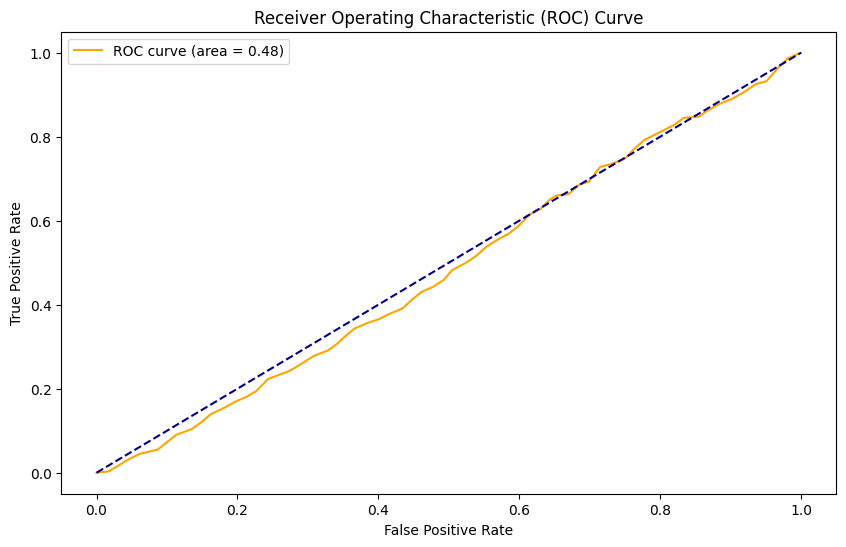

In [ ]:
plot_roc_curve(y, yhat)